# Imports

In [1]:
from scheduling_funtions import *
from constraints import *
from data import *
from model import *


# Creating Data

In [2]:
model = create_model()

In [3]:
#Decomp line
# prev_days, prev_staff_works_shift_on_day = read_shifts_from_file(model, "prev_shifts.txt")

In [4]:
staff = staff_list
ft_staff = filter_data(staff, ft_only_staff_mask)
midnight_staff = filter_data(staff, midnight_staff_mask)
six_month_new_staff = filter_data(staff, staff_in_first_6_months_mask)
not_ft_staff = list_difference(staff, ft_staff)
not_midnight_staff = list_difference(staff, midnight_staff)

shifts = create_data(shift_list)
midnight_shifts = filter_data(shifts, midnight_shifts_mask)
not_midnight_shifts = list_difference(shifts, midnight_shifts)
late_shifts = filter_data(shifts, late_shifts_mask)
day_shifts = filter_data(shifts, day_shifts_mask)
afternoon_shifts = filter_data(shifts, afternoon_shifts_mask)
ft_shifts = filter_data(shifts, ft_shifts_mask)
not_ft_shifts = list_difference(shifts, ft_shifts)
on_call_shifts = filter_data(shifts, on_call_shifts_mask)
not_on_call_shifts = list_difference(shifts, on_call_shifts)
after_5_shifts = late_shifts + midnight_shifts
after_930_shifts = list_difference(shifts, day_shifts)

days, first_day = create_date_range(1, 1, 2021)
#Decomp line
orig_days = days
# days = prev_days + days
fris = fridays(days, first_day)
weekdays = mondays(days, first_day) + tuesdays(days, first_day) + wednesdays(days, first_day) + thursdays(days, first_day) + fris
sats = saturdays(days, first_day)
suns = sundays(days, first_day)
weekends = sats + suns

In [5]:
import random
requests = [
    # # staff, day, shift, weight
    # # if shift is -1 make it all shifts
]
for m in staff:
    for i in range(random.randint(1,6)):
        d = random.choice([random.choice(days)])
        s = random.choice([random.choice(shifts)] * 10 + [-1])
        w = random.choice([LOW, MID, HIGH, MAX])
        requests.append((m, d, s, w))

print(requests)

[('Olivia', 12, 7, 40), ('Emma', 29, 4, 24), ('Emma', 29, 0, 12), ('Emma', 12, 1, 40), ('Emma', 6, 3, 12), ('Emma', 18, 4, 24), ('Ava', 21, 2, 24), ('Ava', 0, 4, 60), ('Ava', 8, 5, 60), ('Ava', 22, 6, 40), ('Charlotte', 8, 4, 12), ('Charlotte', 26, 9, 24), ('Charlotte', 1, 10, 12), ('Sophia', 21, 10, 12), ('Sophia', 16, 7, 12), ('Sophia', 28, 5, 60), ('Amelia', 11, 7, 12), ('Isabella', 2, 4, 12), ('Isabella', 14, 3, 12), ('Mia', 11, 2, 24), ('Mia', 25, 4, 24), ('Evelyn', 19, 0, 24), ('Evelyn', 23, 2, 12), ('Harper', 0, -1, 40), ('Harper', 2, 3, 12), ('Harper', 28, 5, 12), ('Harper', 3, 2, 12), ('Harper', 20, 5, 40), ('Harper', 26, 0, 60), ('Camila', 16, 2, 40), ('Camila', 1, 9, 60), ('Gianna', 18, 9, 12), ('Abigail', 6, 10, 24), ('Abigail', 11, 4, 60), ('Abigail', 17, 3, 12), ('Luna', 27, 2, 24), ('Luna', 11, 0, 24), ('Luna', 19, 11, 24), ('Ella', 30, 0, 24), ('Ella', 19, 0, 24), ('Elizabeth', 11, 6, 40), ('Elizabeth', 22, 7, 24), ('Elizabeth', 23, -1, 40), ('Elizabeth', 5, 2, 60), ('E

# Creating the Model

In [6]:
staff_works_shift_on_day = create_model_variables_long(model, "staff_works_shift_on_day", staff, orig_days, shifts)

#Decomp line
# staff_works_shift_on_day = {**prev_staff_works_shift_on_day, **staff_works_shift_on_day}

staff_works_day = create_model_variables_with_sum(model, "staff_works_day", staff_works_shift_on_day, staff, days, shifts)
staff_doesnt_work_day = not_dict(staff_works_day)
staff_works_afternoon_shift = create_model_variables_with_sum(model, "staff_works_afternoon_shift", staff_works_shift_on_day, staff, days, afternoon_shifts)
staff_doesnt_work_afternoon_shift = not_dict(staff_works_afternoon_shift)
staff_works_midnight_shift = create_model_variables_with_sum(model, "staff_works_midnight_shift", staff_works_shift_on_day, staff, days, midnight_shifts)
staff_works_on_call_shift = create_model_variables_with_sum(model, "staff_works_on_call_shift", staff_works_shift_on_day, staff, days, on_call_shifts)
staff_works_ft_shift = create_model_variables_with_sum(model, "staff_works_ft_shift", staff_works_shift_on_day, staff, days, ft_shifts)
staff_works_late_shift = create_model_variables_with_sum(model, "staff_works_late_shift", staff_works_shift_on_day, staff, days, late_shifts)
staff_doesnt_work_late_shift = not_dict(staff_works_late_shift)
staff_works_after_5_shift = create_model_variables_with_sum(model, "staff_works_after_5_shift", staff_works_shift_on_day, staff, days, after_5_shifts)
staff_doesnt_work_after_5_shift = not_dict(staff_works_after_5_shift)
staff_works_after_930_shift = create_model_variables_with_sum(model, "staff_works_after_930_shift", staff_works_shift_on_day, staff, days, after_930_shifts)
staff_doesnt_work_after_930_shift = not_dict(staff_works_after_930_shift)
staff_works_day_shift = create_model_variables_with_sum(model, "staff_works_day_shift", staff_works_shift_on_day, staff, days, day_shifts)
staff_doesnt_work_day_shift = not_dict(staff_works_day_shift)
staff_productivities = create_staff_variables(model, "staff_productivity", staff_productivity_mask, 0, 6, staff_works_shift_on_day, staff, days, shifts)

obj_int_vars, obj_int_coeffs = empty_minimize_constraints()
obj_bool_vars, obj_bool_coeffs = empty_minimize_constraints()

# Adding Constraints to the Model

In [7]:
max_days_worked_hard_max = 7
max_days_worked_soft_max = 3
max_days_worked_max_cost = MAX

min_days_off_after_midnight_hard_min = 2
min_days_off_after_midnight_soft_min = 4
min_days_off_after_midnight_min_cost = HIGH

max_midnights_in_a_row_hard_max = 2
max_midnights_in_a_row_soft_max = 1
max_midnights_in_a_row_max_cost = MAX

no_late_shift_before_time_off_hard_min = 1
no_late_shift_before_time_off_soft_min = 0
no_late_shift_before_time_off_min_cost = NONE

on_call_rules_before_hard_min = 1
on_call_rules_before_soft_min = 0
on_call_rules_before_min_cost = NONE

on_call_rules_after_hard_min = 1
on_call_rules_after_soft_min = 0
on_call_rules_after_min_cost = NONE

days_off_after_consecutive_shifts_hard_min = 2
days_off_after_consecutive_shifts_soft_min = 3
days_off_after_consecutive_shifts_min_cost = HIGH

days_off_between_late_and_day_shifts_hard_min = 2
days_off_between_late_and_day_shifts_soft_min = 3
days_off_between_late_and_day_shifts_min_cost = HIGH

days_off_between_late_and_afternoon_shifts_hard_min = 2
days_off_between_late_and_afternoon_shifts_soft_min = 3
days_off_between_late_and_afternoon_shifts_min_cost = HIGH

late_shifts_in_a_row_hard_max = 7
late_shifts_in_a_row_soft_max = 3
late_shifts_in_a_row_max_cost = MAX

late_shifts_in_weeks_hard_min = 0
late_shifts_in_weeks_soft_min = 0
late_shifts_in_weeks_min_cost = NONE
late_shifts_in_weeks_hard_max = 14
late_shifts_in_weeks_soft_max = 5
late_shifts_in_weeks_max_cost = MAX

avoid_consecutive_ft_shifts_hard_max = 2
avoid_consecutive_ft_shifts_soft_max = 1
avoid_consecutive_ft_shifts_max_cost = MID

no_nightshifts_before_weekend_off_hard_min = 0
no_nightshifts_before_weekend_off_soft_min = 1
no_nightshifts_before_weekend_off_min_cost = HIGH

minimize_split_weekends_cost = MAX

equalize_weekends_cost = 4
equalize_night_shifts_cost = 4
equalize_late_shifts_cost = 4
equalize_day_shifts_cost = 2
equalize_afternoon_shifts_cost = 2
equalize_weekdays_cost = 1


In [8]:
all_shifts_taken(model,
                staff_works_shift_on_day,
                staff,
                days,
                shifts)

max_days_worked_obj = max_days_worked(model,
                staff_works_day,
                staff,
                days,
                max_days_worked_hard_max,
                max_days_worked_soft_max,
                max_days_worked_max_cost)

obj_bool_vars.extend(max_days_worked_obj[0])
obj_bool_coeffs.extend(max_days_worked_obj[1])

min_days_off_after_midnight_obj = min_days_off_after_midnight(model,
                            staff_doesnt_work_day,
                            staff_works_midnight_shift, 
                            staff, 
                            days, 
                            min_days_off_after_midnight_hard_min, 
                            min_days_off_after_midnight_soft_min, 
                            min_days_off_after_midnight_min_cost)

obj_bool_vars.extend(min_days_off_after_midnight_obj[0])
obj_bool_coeffs.extend(min_days_off_after_midnight_obj[1])

midnight_physicians(model,
                    staff_works_shift_on_day,
                    midnight_staff,
                    days,
                    not_midnight_shifts)

no_midnights_within_six_months(model,
                                staff_works_shift_on_day,
                                six_month_new_staff,
                                days,
                                midnight_shifts)

max_midnights_in_a_row_obj = max_midnights_in_a_row(model,
                        staff_works_midnight_shift,
                        not_midnight_staff,
                        days,
                        max_midnights_in_a_row_hard_max,
                        max_midnights_in_a_row_soft_max,
                        max_midnights_in_a_row_max_cost)

obj_bool_vars.extend(max_midnights_in_a_row_obj[0])
obj_bool_coeffs.extend(max_midnights_in_a_row_obj[1])

ft_physicians(model,
            staff_works_shift_on_day,
            ft_staff,
            days,
            not_ft_shifts)

no_late_shift_before_time_off_obj = no_late_shift_before_time_off(model,
                            staff_works_day,
                            staff_doesnt_work_after_5_shift,
                            staff,
                            requests,
                            no_late_shift_before_time_off_hard_min,
                            no_late_shift_before_time_off_soft_min,
                            no_late_shift_before_time_off_min_cost)

obj_bool_vars.extend(no_late_shift_before_time_off_obj[0])
obj_bool_coeffs.extend(no_late_shift_before_time_off_obj[1])
                            
on_call_rules_before_obj = on_call_rules_before(model,
                    staff_works_on_call_shift,
                    staff_doesnt_work_after_930_shift,
                    staff,
                    days,
                    on_call_rules_before_hard_min,
                    on_call_rules_before_soft_min,
                    on_call_rules_before_min_cost)

obj_bool_vars.extend(on_call_rules_before_obj[0])
obj_bool_coeffs.extend(on_call_rules_before_obj[1])

on_call_rules_after_obj = on_call_rules_after(model,
                    staff_works_on_call_shift,
                    staff_doesnt_work_day_shift,
                    staff,
                    days,
                    on_call_rules_after_hard_min,
                    on_call_rules_after_soft_min,
                    on_call_rules_after_min_cost)

obj_bool_vars.extend(on_call_rules_after_obj[0])
obj_bool_coeffs.extend(on_call_rules_after_obj[1])

days_off_after_consecutive_shifts_obj = days_off_after_consecutive_shifts(model,
                                staff_works_day,
                                staff_works_day,
                                staff,
                                days,
                                days_off_after_consecutive_shifts_hard_min,
                                days_off_after_consecutive_shifts_soft_min,
                                days_off_after_consecutive_shifts_min_cost)

obj_bool_vars.extend(days_off_after_consecutive_shifts_obj[0])
obj_bool_coeffs.extend(days_off_after_consecutive_shifts_obj[1])

In [9]:
transitions_constraints_obj = transitions_constraints(model,
                        staff_works_shift_on_day,
                        staff,
                        days)

obj_bool_vars.extend(transitions_constraints_obj[0])
obj_bool_coeffs.extend(transitions_constraints_obj[1])

days_off_between_late_and_day_shifts_obj = days_off_between_late_and_day_shifts(model,
                                    staff_doesnt_work_day,
                                    staff_works_day_shift,
                                    staff_works_late_shift,
                                    staff,
                                    days,
                                    days_off_between_late_and_day_shifts_hard_min,
                                    days_off_between_late_and_day_shifts_soft_min,
                                    days_off_between_late_and_day_shifts_min_cost)

obj_bool_vars.extend(days_off_between_late_and_day_shifts_obj[0])
obj_bool_coeffs.extend(days_off_between_late_and_day_shifts_obj[1])

days_off_between_late_and_afternoon_shifts_obj = days_off_between_late_and_afternoon_shifts(model,
                                    staff_doesnt_work_day,
                                    staff_works_afternoon_shift,
                                    staff_works_late_shift,
                                    staff,
                                    days,
                                    days_off_between_late_and_afternoon_shifts_hard_min,
                                    days_off_between_late_and_afternoon_shifts_soft_min,
                                    days_off_between_late_and_afternoon_shifts_min_cost)

obj_bool_vars.extend(days_off_between_late_and_afternoon_shifts_obj[0])
obj_bool_coeffs.extend(days_off_between_late_and_afternoon_shifts_obj[1])

late_shifts_in_a_row_obj = late_shifts_in_a_row(model,
                    staff_works_late_shift,
                    staff,
                    days,
                    late_shifts_in_a_row_hard_max,
                    late_shifts_in_a_row_soft_max,
                    late_shifts_in_a_row_max_cost)

obj_bool_vars.extend(late_shifts_in_a_row_obj[0])
obj_bool_coeffs.extend(late_shifts_in_a_row_obj[1])

late_shifts_in_weeks_obj = late_shifts_in_weeks(model,
                        staff_works_late_shift,
                        staff,
                        days,
                        late_shifts_in_weeks_hard_min,
                        late_shifts_in_weeks_soft_min,
                        late_shifts_in_weeks_min_cost,
                        late_shifts_in_weeks_hard_max,
                        late_shifts_in_weeks_soft_max,
                        late_shifts_in_weeks_max_cost)

obj_int_vars.extend(late_shifts_in_weeks_obj[0])
obj_int_coeffs.extend(late_shifts_in_weeks_obj[1])

avoid_consecutive_ft_shifts_obj = avoid_consecutive_ft_shifts(model,
                        staff_works_ft_shift,
                        not_midnight_staff,
                        days,
                        avoid_consecutive_ft_shifts_hard_max,
                        avoid_consecutive_ft_shifts_soft_max,
                        avoid_consecutive_ft_shifts_max_cost)

obj_int_vars.extend(avoid_consecutive_ft_shifts_obj[0])
obj_int_coeffs.extend(avoid_consecutive_ft_shifts_obj[1])

In [10]:
equalize_weekends_obj = equalize_weekends(model,
                    staff_works_day,
                    staff,
                    weekends,
                    equalize_weekends_cost,
                    triangle_costs(len(shifts), len(weekends), len(staff)))

obj_int_vars.extend(equalize_weekends_obj[0])
obj_int_coeffs.extend(equalize_weekends_obj[1])

minimize_split_weekends_obj = minimize_split_weekends(model,
                        staff_works_day,
                        staff,
                        sats,
                        suns,
                        minimize_split_weekends_cost)

obj_int_vars.extend(minimize_split_weekends_obj[0])
obj_int_coeffs.extend(minimize_split_weekends_obj[1])

equalize_night_shifts_obj = equalize_night_shifts(model,
                        staff_works_midnight_shift,
                        staff,
                        days,
                        equalize_night_shifts_cost,
                        triangle_costs(len(midnight_shifts), len(days), len(staff)))

obj_int_vars.extend(equalize_night_shifts_obj[0])
obj_int_coeffs.extend(equalize_night_shifts_obj[1])

no_nightshifts_before_weekend_off_obj = no_nightshifts_before_weekend_off(model,
                                staff_works_day,
                                staff_doesnt_work_after_5_shift,
                                staff,
                                fris,
                                sats,
                                no_nightshifts_before_weekend_off_hard_min,
                                no_nightshifts_before_weekend_off_soft_min,
                                no_nightshifts_before_weekend_off_min_cost)

obj_bool_vars.extend(no_nightshifts_before_weekend_off_obj[0])
obj_bool_coeffs.extend(no_nightshifts_before_weekend_off_obj[1])

equalize_late_shifts_obj = equalize_late_shifts(model,
                    staff_works_late_shift,
                    staff,
                    days,
                    equalize_late_shifts_cost,
                    triangle_costs(len(late_shifts), len(days), len(staff)))

obj_int_vars.extend(equalize_late_shifts_obj[0])
obj_int_coeffs.extend(equalize_late_shifts_obj[1])

equalize_day_shifts_obj = equalize_day_shifts(model,
                    staff_works_day_shift,
                    staff,
                    days,
                    equalize_day_shifts_cost,
                    triangle_costs(len(day_shifts), len(days), len(staff)))

obj_int_vars.extend(equalize_day_shifts_obj[0])
obj_int_coeffs.extend(equalize_day_shifts_obj[1])

equalize_afternoon_shifts_obj = equalize_afternoon_shifts(model,
                            staff_works_afternoon_shift,
                            staff,
                            days,
                            equalize_afternoon_shifts_cost,
                            triangle_costs(len(afternoon_shifts), len(days), len(staff)))

obj_int_vars.extend(equalize_afternoon_shifts_obj[0])
obj_int_coeffs.extend(equalize_afternoon_shifts_obj[1])

equalize_weekdays_obj = equalize_weekdays(model,
                    staff_works_day,
                    staff,
                    weekdays,
                    equalize_weekdays_cost,
                    triangle_costs(len(shifts), len(weekdays), len(staff)))

obj_int_vars.extend(equalize_weekdays_obj[0])
obj_int_coeffs.extend(equalize_weekdays_obj[1])

In [11]:
apply_requests_obj = apply_requests(staff_works_shift_on_day,
                staff_works_day,
                days,
                requests)

obj_int_vars.extend(apply_requests_obj[0])
obj_int_coeffs.extend(apply_requests_obj[1])

apply_productivity_obj = apply_productivity(model,
                    staff_productivities,
                    staff,
                    days,
                    shifts,
                    3)

obj_int_vars.extend(apply_productivity_obj[0])
obj_int_coeffs.extend(apply_productivity_obj[1])

# Solving the Model

In [12]:
# All constraints together takes 1.5 hours to find a feasible solution
import time

start = time.time()

model.Minimize(
        sum(obj_bool_vars[i] * obj_bool_coeffs[i]
            for i in range(len(obj_bool_vars))) +
            sum(obj_int_vars[i] * obj_int_coeffs[i]
            for i in range(len(obj_int_vars))))

solver = create_solver(600)
status = solver.Solve(model)

print(solver.StatusName(status))
import collections
results = collections.defaultdict(list)

if status == FEASIBLE or status == OPTIMAL:

    print('Maximum of objective function: %i' % solver.ObjectiveValue())
    print()
    for d in days:
        print('Day', d)
        for s in shifts:
            for m in staff:
                if solver.Value(staff_works_shift_on_day[(m, d, s)]) == 1:
                    results[d].append(staff_list[staff.index(m)])
                    print(m, 'works shift', shift_list[s])
        print()

end = time.time()
print(f"time elapsed: {end - start}")

results = [v for k, v in results.items()]

FEASIBLE
Maximum of objective function: 9736

Day 0
Avery works shift 0700 - 1500
Eleanor works shift 0730 - 1530 (FT)
Sofia works shift 0930 - 1730
Victoria works shift 1200 - 2000
Camila works shift 1400 - 2200
Mia works shift 1530 - 2330 (FT)
Isabella works shift 1600 - 2400
Ava works shift 1800 - 0200
Elizabeth works shift 2000 - 0400
Olivia works shift 2200 - 0400
Madison works shift 2359 - 0700
Layla works shift On Call

Day 1
Nora works shift 0700 - 1500
Chloe works shift 0730 - 1530 (FT)
Abigail works shift 0930 - 1730
Grace works shift 1200 - 2000
Penelope works shift 1400 - 2200
Charlotte works shift 1530 - 2330 (FT)
Eleanor works shift 1600 - 2400
Aria works shift 1800 - 0200
Emma works shift 2000 - 0400
Olivia works shift 2200 - 0400
Sofia works shift 2359 - 0700
Scarlett works shift On Call

Day 2
Gianna works shift 0700 - 1500
Luna works shift 0730 - 1530 (FT)
Victoria works shift 0930 - 1730
Harper works shift 1200 - 2000
Scarlett works shift 1400 - 2200
Mia works shift 

In [13]:
print(solver.ResponseStats())

CpSolverResponse summary:
status: FEASIBLE
objective: 9736
best_bound: 218
booleans: 112231
conflicts: 68
branches: 413367
propagations: 901858
integer_propagations: 2029583
restarts: 222355
lp_iterations: 335932
walltime: 360.646
usertime: 360.646
deterministic_time: 771.792
primal_integral: 9360.98



In [14]:
# Saving to Excel
import pandas as pd

df = pd.DataFrame(results,
index = days,
columns = shift_list)

df.head()

df.to_csv("output.csv")

# Tests

In [15]:
staff_works_day_results = {}
staff_works_midnight_shift_results = {}
staff_works_late_shift_results = {}
staff_works_day_shift_results = {}
staff_works_shift_on_day_results = {}
staff_works_ft_shift_results = {}
staff_works_after_5_shift_results = {}
staff_works_on_call_shift_results = {}
staff_works_after_930_shift_results = {}
staff_works_afternoon_shift_results = {}
staff_doesnt_work_day_results = {}
staff_doesnt_work_after_930_shift_results = {}
staff_doesnt_work_day_shift_results = {}
staff_doesnt_work_after_5_shift_results = {}
for m in staff:
    staff_works_day_results[m] = [solver.Value(staff_works_day[m, d]) for d in days]
    staff_doesnt_work_day_results[m] = [solver.Value(staff_doesnt_work_day[m, d]) for d in days]
    staff_works_midnight_shift_results[m] = [solver.Value(staff_works_midnight_shift[m, d]) for d in days]
    staff_works_late_shift_results[m] = [solver.Value(staff_works_late_shift[m, d]) for d in days]
    staff_works_day_shift_results[m] = [solver.Value(staff_works_day_shift[m, d]) for d in days]
    staff_works_ft_shift_results[m] = [solver.Value(staff_works_ft_shift[m, d]) for d in days]
    staff_works_after_5_shift_results[m] = [solver.Value(staff_works_after_5_shift[m,d]) for d in days]
    staff_works_on_call_shift_results[m] = [solver.Value(staff_works_on_call_shift[m,d]) for d in days]
    staff_works_after_930_shift_results[m] = [solver.Value(staff_works_after_930_shift[m,d]) for d in days]
    staff_works_afternoon_shift_results[m] = [solver.Value(staff_works_afternoon_shift[m,d]) for d in days]
    staff_doesnt_work_after_930_shift_results[m] = [solver.Value(staff_doesnt_work_after_930_shift[m,d]) for d in days]
    staff_doesnt_work_day_shift_results[m] = [solver.Value(staff_doesnt_work_day_shift[m,d]) for d in days]
    staff_doesnt_work_after_5_shift_results[m] = [solver.Value(staff_doesnt_work_after_5_shift[m,d]) for d in days]
    for d in days:
        staff_works_shift_on_day_results[m, d] = [solver.Value(staff_works_shift_on_day[(m, d, s)]) for s in shifts]

## Hard Constraints

In [16]:
from test import *

all_shifts_taken_test(staff_works_shift_on_day_results, staff, days, shifts)
  
no_two_shifts_on_same_day_test(staff_works_shift_on_day_results)

print(max_days_worked_max_cost)
max_days_worked_test(staff_works_day_results,
                    max_days_worked_hard_max,
                    max_days_worked_soft_max, 
                    obj_result(solver, max_days_worked_obj))

print(min_days_off_after_midnight_min_cost)
min_days_off_after_midnight_test(staff_doesnt_work_day_results,
                                 staff_works_midnight_shift_results,
                                 min_days_off_after_midnight_hard_min, 
                                 min_days_off_after_midnight_soft_min,
                                 obj_result(solver, min_days_off_after_midnight_obj))

midnight_physicians_test(staff_works_shift_on_day_results, staff, shifts)

no_midnights_within_six_months_test(staff_works_midnight_shift_results, staff, shifts)

print(max_midnights_in_a_row_max_cost)
max_midnights_in_a_row_test(staff_works_midnight_shift_results, 
                            max_midnights_in_a_row_hard_max,
                            max_midnights_in_a_row_soft_max,
                            obj_result(solver, max_midnights_in_a_row_obj))

ft_physicians_test(staff_works_shift_on_day_results, staff, shifts)

print(no_late_shift_before_time_off_min_cost)
no_late_shift_before_time_off_test(staff_works_day_results, staff_works_after_5_shift_results, requests)

print(on_call_rules_before_min_cost)
on_call_rules_before_test(staff_doesnt_work_after_930_shift_results,
                            staff_works_on_call_shift_results,
                            on_call_rules_before_hard_min,
                            on_call_rules_before_soft_min, 
                            obj_result(solver, on_call_rules_before_obj))

print(on_call_rules_after_min_cost)
on_call_rules_after_test(staff_doesnt_work_day_shift_results, 
                        staff_works_on_call_shift_results, 
                        on_call_rules_after_hard_min, 
                        on_call_rules_after_soft_min, 
                        obj_result(solver, on_call_rules_after_obj))

print(days_off_after_consecutive_shifts_min_cost)
days_off_after_consecutive_shifts_test(staff_doesnt_work_day_results, 
                                        staff_works_day_results, 
                                        days_off_after_consecutive_shifts_hard_min, 
                                        days_off_after_consecutive_shifts_soft_min, 
                                        obj_result(solver, days_off_after_consecutive_shifts_obj))

print("ALL HARD CONSTRAINTS SATISFIED")

60
Max days worked consecutively
Objective function: 300
	3 from range 3 to 7: 0

	4 from range 3 to 7: 2

	5 from range 3 to 7: 1

	6 from range 3 to 7: 0

	7 from range 3 to 7: 0


40
Min days off after midnight shift
Objective function: 280
	2 from range 2 to 4: 0

	3 from range 2 to 4: 7

	4 from range 2 to 4: 9


60
Max midnights worked consecutively
Objective function: 240
	1 from range 1 to 2: 23

	2 from range 1 to 2: 4


0
0
No shifts after 930 before on call
Objective function: 0

0
No early morning shifts post on call
Objective function: 0

40
days_off_after_consecutive_shifts
Objective function: 0
	2 from range 2 to 3: 0

	3 from range 2 to 3: 0


ALL HARD CONSTRAINTS SATISFIED


## Pie in the sky

In [17]:
#Ensure requests work as intended
number_of_requests_respected = 0
number_of_requests_disrespected = 0

for staff2, day2, shift2, coef in requests:
    if shift2 == -1 and coef > 0:
        if staff_works_day_results[staff2][day2]:
            print(coef)
            number_of_requests_disrespected += 1
        else:
            number_of_requests_respected += 1
    elif shift2 == -1 and coef < 0:
        if staff_works_day_results[staff2][day2]:
            number_of_requests_respected += 1
        else:
            print(coef)
            number_of_requests_disrespected += 1
    elif coef > 0:
        if staff_works_shift_on_day_results[staff2, day2][shift2]:
            print(coef)
            number_of_requests_disrespected += 1
        else:
            number_of_requests_respected += 1
    elif coef < 0:
        if staff_works_shift_on_day_results[staff2, day2][shift2]:
            number_of_requests_respected += 1
        else:
            number_of_requests_disrespected += 1

print(f"number of requests respected: {number_of_requests_respected}")
print(f"number of requests disrespected: {number_of_requests_disrespected}")

12
60
12
60
number of requests respected: 104
number of requests disrespected: 4


In [18]:
# Check productivity
productivity_under = 0
productivity_over = 0

for d in days:
    for wind in window(shifts[:-1], 3):
        prod = [solver.Value(staff_productivities[m,d,s])
        for m in staff 
        for s in wind]
        sums = sum(prod)
        if sums < 6:
            productivity_under += 1
            print((6 - sums) * LOW)
        if sums > 15:
            productivity_over += 1

print(f"number of times theres too little productivity: {productivity_under}")
print(f"number of times theres too much productivity: {productivity_over}")

36
12
12
12
12
12
number of times theres too little productivity: 6
number of times theres too much productivity: 0


## Soft Constraints

In [19]:
transition_constraint_test(staff_works_shift_on_day_results, days)

print(days_off_between_late_and_day_shifts_min_cost)
days_off_between_late_and_day_shifts_test(staff_doesnt_work_day_results,
                                            staff_works_late_shift_results,
                                            staff_works_day_shift_results, 
                                            days_off_between_late_and_day_shifts_hard_min, 
                                            days_off_between_late_and_day_shifts_soft_min,
                                            obj_result(solver, days_off_between_late_and_day_shifts_obj))

print(days_off_between_late_and_afternoon_shifts_min_cost)
days_off_between_late_and_afternoon_shifts_test(staff_doesnt_work_day_results,
                                                staff_works_late_shift_results, 
                                                staff_works_afternoon_shift_results, 
                                                days_off_between_late_and_afternoon_shifts_hard_min, 
                                                days_off_between_late_and_afternoon_shifts_soft_min, 
                                                obj_result(solver, days_off_between_late_and_afternoon_shifts_obj))

print(late_shifts_in_a_row_max_cost)
late_shifts_in_a_row_test(staff_works_late_shift_results,
                         late_shifts_in_a_row_hard_max, 
                         late_shifts_in_a_row_soft_max, 
                         obj_result(solver, late_shifts_in_a_row_obj))

print(late_shifts_in_weeks_min_cost)
print(late_shifts_in_weeks_max_cost)
late_shifts_in_two_weeks_test(staff_works_late_shift_results,
                                late_shifts_in_weeks_hard_max,
                                late_shifts_in_weeks_soft_max,
                                obj_result(solver, late_shifts_in_weeks_obj))

print(avoid_consecutive_ft_shifts_max_cost)
avoid_consecutive_ft_shifts_test(staff_works_ft_shift_results,
                                 avoid_consecutive_ft_shifts_hard_max, 
                                 avoid_consecutive_ft_shifts_soft_max,
                                 obj_result(solver, avoid_consecutive_ft_shifts_obj))

Number of times shifts jump forwards 2.5 hours: 39
Number of times shifts jump backwards 1.5 hours: 39

40
days_off_between_late_and_day_shifts
Objective function: 0
	2 from range 2 to 3: 0

	3 from range 2 to 3: 0


40
days_off_between_late_and_afternoon_shifts
Objective function: 0
	2 from range 2 to 3: 0

	3 from range 2 to 3: 0


60
days_off_between_late_and_afternoon_shifts
Objective function: 0
	3 from range 3 to 7: 0

	4 from range 3 to 7: 0

	5 from range 3 to 7: 0

	6 from range 3 to 7: 0

	7 from range 3 to 7: 0


0
60
late_shifts_in_two_weeks_test
Objective function: 0
	5 from range 5 to 14: 0

	6 from range 5 to 14: 0

	7 from range 5 to 14: 0

	8 from range 5 to 14: 0

	9 from range 5 to 14: 0

	10 from range 5 to 14: 0

	11 from range 5 to 14: 0

	12 from range 5 to 14: 0

	13 from range 5 to 14: 0

	14 from range 5 to 14: 3

24
days_off_between_late_and_afternoon_shifts
Objective function: 96
	1 from range 1 to 2: 50

	2 from range 1 to 2: 4




## Goals

In [20]:
weekends_worked = {}
weekdays_worked = {}
first = {}
second = {}
for m in staff:
    weekends_worked[m] = [solver.Value(staff_works_day[m, d]) for d in weekends]
    weekdays_worked[m] = [solver.Value(staff_works_day[m, d]) for d in weekdays]
    first[m] = [solver.Value(staff_doesnt_work_after_5_shift[m, d])
                    for d in fris] + [model.NewConstant(1)] * no_nightshifts_before_weekend_off_hard_min
    second[m] = [model.NewConstant(1)] * no_nightshifts_before_weekend_off_hard_min + [solver.Value(staff_works_day[m, d]) for d in sats]

In [21]:
equalize_weekends_test(weekends_worked, triangle_costs(len(shifts), len(weekends), len(staff)), obj_result(solver, equalize_weekends_obj))
equalize_night_shifts_test(staff_works_midnight_shift_results, triangle_costs(len(midnight_shifts), len(days), len(staff)), obj_result(solver, equalize_night_shifts_obj))
equalize_late_shifts_test(staff_works_late_shift_results, triangle_costs(len(late_shifts), len(days), len(staff)), obj_result(solver, equalize_late_shifts_obj))
equalize_day_shifts_test(staff_works_day_shift_results, triangle_costs(len(day_shifts), len(days), len(staff)), obj_result(solver, equalize_day_shifts_obj))
equalize_afternoon_shifts_test(staff_works_afternoon_shift_results, triangle_costs(len(afternoon_shifts), len(days), len(staff)), obj_result(solver, equalize_afternoon_shifts_obj))
equalize_weekdays_test(weekdays_worked, triangle_costs(len(shifts), len(weekdays), len(staff)), obj_result(solver, equalize_weekdays_obj))

print(minimize_split_weekends_cost)
minimize_split_weekends_test(solver, staff_works_day, staff, sats, suns, obj_result(solver, minimize_split_weekends_obj))
print()

print(no_nightshifts_before_weekend_off_min_cost)
no_nightshifts_before_weekend_off_test(first, 
                                        second, 
                                        no_nightshifts_before_weekend_off_hard_min, 
                                        no_nightshifts_before_weekend_off_soft_min, 
                                        obj_result(solver, no_nightshifts_before_weekend_off_obj))

Weekend Equalization
Objective function: 0
Difference from target of 4: 0

night shift Equalization
Objective function: 156
Difference from target of 2: 29

night shift Equalization
Objective function: 144
Difference from target of 4: 27

night shift Equalization
Objective function: 144
Difference from target of 4: 27

night shift Equalization
Objective function: 152
Difference from target of 5: 26

Weekend Equalization
Objective function: 88
Difference from target of 9: 18

60
minimize_split_weekends_test
Objective function: 4920
Number of split weekends: 82

40
no_nightshifts_before_weekend_off
Objective function: 0
	0 from range 0 to 1: 0

	1 from range 0 to 1: 0




In [22]:
new_works = {k:v for (k,v) in staff_works_shift_on_day.items() if k[1] >= 0}
save_shifts_to_file("prev_shifts.txt2", new_works, staff, len(days), len(shift_list), solver)

Employee Satisfaction

In [23]:
staff_obj = {}
for m in staff:
    ints = sum(list(map(lambda x: solver.Value(x[0]) * x[1], (list(filter(lambda x: m in str(x), zip(obj_int_vars, obj_int_coeffs)))))))
    bools = sum(list(map(lambda x: solver.Value(x[0]) * x[1], (list(filter(lambda x: m in str(x), zip(obj_bool_vars, obj_bool_coeffs)))))))
    staff_obj[m] = ints + bools
print(staff_obj)
print(sum(staff_obj.values()))

{'Olivia': 404, 'Emma': 356, 'Ava': 184, 'Charlotte': 400, 'Sophia': 380, 'Amelia': 200, 'Isabella': 368, 'Mia': 272, 'Evelyn': 360, 'Harper': 368, 'Camila': 144, 'Gianna': 492, 'Abigail': 260, 'Luna': 280, 'Ella': 288, 'Elizabeth': 148, 'Sofia': 440, 'Emily': 420, 'Avery': 392, 'Mila': 420, 'Aria': 376, 'Scarlett': 308, 'Penelope': 212, 'Layla': 272, 'Chloe': 440, 'Victoria': 320, 'Madison': 220, 'Eleanor': 384, 'Grace': 260, 'Nora': 272}
9640


In [24]:
import matplotlib.pyplot as plt

dict_keys(['Olivia', 'Emma', 'Ava', 'Charlotte', 'Sophia', 'Amelia', 'Isabella', 'Mia', 'Evelyn', 'Harper', 'Camila', 'Gianna', 'Abigail', 'Luna', 'Ella', 'Elizabeth', 'Sofia', 'Emily', 'Avery', 'Mila', 'Aria', 'Scarlett', 'Penelope', 'Layla', 'Chloe', 'Victoria', 'Madison', 'Eleanor', 'Grace', 'Nora'])


<BarContainer object of 30 artists>

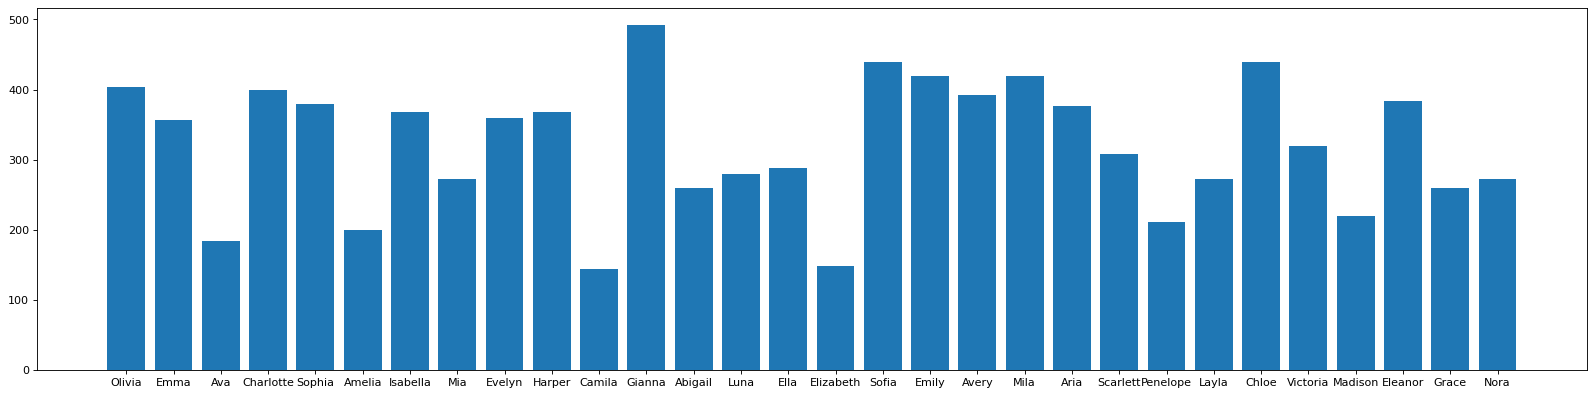

In [25]:
X, Y = staff_obj.keys(), staff_obj.values()
print(X)
plt.figure(figsize=(25, 6), dpi=80)
plt.bar(X, Y)

{'whiskers': [<matplotlib.lines.Line2D at 0x229aafbce20>,
 'caps': [<matplotlib.lines.Line2D at 0x229aafcf4f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x229aafbc9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x229aafcfc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x229aafcffa0>],
 'means': []}

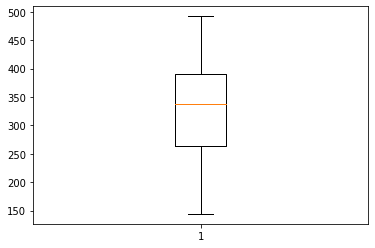

In [26]:
plt.boxplot(Y)